In [41]:
import numpy as np 
import pandas as pd
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

import statsmodels.stats.multitest as multitest

import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText




# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

In [2]:
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp_dms.csv", index_col = 0)

# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all


# df_gcamp = pd.read_csv("data/timelocked_gcamp_all.csv", index_col = 0)
# df_src = df_gcamp 
df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



In [3]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [4]:
df_DMS = df_corr_all[df_corr_all['RecordLoc'] == 'DMS']
df_DMS_CB = df_corr_all[df_corr_all['RecordLoc'] == 'DMS_CB']
# look at DMS terminals first
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS


# Multiple Kernel Analysis

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


output pdf for ai file 


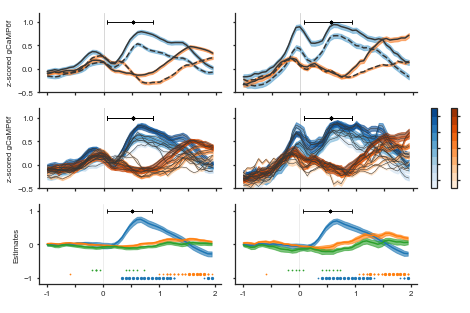

In [100]:
SZ = 8

SZ_S = 6

# no cell-body
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = ''
ylims = [[-0.5, 1.2], [-0.5, 1.2]]
figure = plt.figure(figsize=(7.5, 5))
subfigs = np.array([['a', 'b', 'c'], ['d', 'e', 'f']])
gs = gridspec.GridSpec(3, 4,
                       width_ratios=[3, 3, 0.1, 0.1], height_ratios = [ 1, 1, 1])


num_Q_bins = 10
gs.update(wspace=0.15)


line_styles = ['--', '-']

df_lat_sum = pd.read_csv("data/lat_summary.csv")
    
for num_col, [df_src, src_name] in enumerate(zip([df_DMS, df_DMS_CB], ['DMS', 'DMS_CB'])):
        

    df_lat_i = df_lat_sum[(df_lat_sum["Latency_type"] == "Latency_prez") & (df_lat_sum["RecordLoc"] == src_name)]
    lat_mean = df_lat_i["Mean"]
    lat_5 = df_lat_i["lower_5"].values[0]
    lat_95 = df_lat_i["upper_95"].values[0]

    qlims = np.unique(pd.cut(df_src['Q_ch_diff'], num_Q_bins).dropna())
    
    for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):

        j = 0
        timelocked = 'g_np'
        tl_name = 'Lever Presentation' 
        palettes = [ 'Blues', 'Oranges']


        if tl_name == 'Reward':
            categories = [1, 0]
            column = 'Reward'
            cat_names = ['CS+', 'CS-']
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            cat_names = categories


        # legend plotting 1. colorbar for the q values 

        if num_col == 1:
            lax2 = plt.subplot(gs[i , -2])

            for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):

                color_palette = sns.color_palette(palette, len(qlims))


                cmap = ListedColormap(color_palette.as_hex())
                bounds = [x.left for x in qlims] + [qlims[-1].right]
                norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
                if i == 1:

                    lax = plt.subplot(gs[i , j + 2 + p_i ])
                    dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
                    lax.cla()
                    cbar = plt.colorbar(dummy_plot, cax = lax)
                    cbar.ax.set_yticklabels([])
                    cbar.ax.tick_params(length = 2.5)


                    cbar.ax.set_title("", size = SZ)


# deleted code here 
                if i == 0:

                    ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')
                    ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                    lax2.axis('off')

#                     lax_title.axis('off')


        ax = plt.subplot(gs[i, j*3 + num_col])



        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_filtered = df_src[df_src[column] == subcat]

            color_palette = sns.color_palette(palette, len(qlims))



            for l_i, col in zip(lines, color_palette):

                # plot gcamps
                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_filtered[(df_filtered[Q_to_plot] > l_i.left) & (df_filtered[Q_to_plot] <= l_i.right)][timelocked], 0)
                    ls_i = '-'
                    lw = 0.5
                elif src == 'gcamp':
                    gcamp = np.vstack(df_filtered[(df_filtered['Reward_last'] == l_i) & (df_filtered['Stay/Leave'] == 'stay')][timelocked])
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(gcamp, axis = 0)
                    col = color_palette[5]
                    lw = 1.5
                    ls_i = line_styles[l_i]

                error = scipy.stats.sem(y, axis = 0)
                ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)


                plt.ylim(ylims[i])

                if j == 0 and num_col == 0:
                    plt.ylabel('z-scored gCaMP6f', size = SZ)

                    # x axis 

                plt.xlabel('')
                ax.xaxis.set_ticklabels([])
                if num_col == 1:
                    ax.yaxis.set_ticklabels([])


                    # grid lines
    #             ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
        ax.axhline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
                ax.tick_params(labelsize = SZ, length = 2.5)
            # latency
                ax.errorbar(lat_mean, 1.0, xerr =np.array([[lat_5 , lat_95]]).T, fmt = 'D', ms = 2, lw = 0.5, capsize = 2, capthick = 0.5, color = 'k')




    i = 2
    ax = plt.subplot(gs[-1, 0 + num_col ])
    if num_col == 1:
        lax = plt.subplot(gs[-1, 2:])
        lax.axis("off")
    Q_vals = 'Q_ch_diff'

    ylim = [-1.2, 1.2]
    sig = [0.05, 0.01, 0.001]
    sig_sz = [0.5, 1, 5]
    pval_gap = 0.12 

    
    df_src = pd.read_csv('data/'+ src_name + '/Julia_np_corrected.csv')
    df_src = df_src[df_src['Variable']!= 'Intercept']
    df_src.loc[df_src['Variable'] == 'Interact', 'Estimate'] = -df_src[df_src['Variable'] == 'Interact'].Estimate
    df_src.loc[df_src['Variable'] == 'Action:Ips', 'Estimate'] = -df_src[df_src['Variable'] == 'Action:Ips'].Estimate


    num_var = len(np.unique(df_src['Variable']))
    sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable', 
                 ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

    for ln_i, [n, col] in enumerate(zip(df_src['Variable'], 
                                        sns.color_palette('tab10', num_var ))):
        df_i = df_src[df_src['Variable'] == n]
        ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                                 color = col, alpha = 0.6)
        # latency
        

        ax.errorbar(lat_mean, 1.0, xerr =np.array([[lat_5 , lat_95]]).T, fmt = 'D', ms = 2, lw = 0.5, capsize = 2, capthick = 0.5, color = 'k')

        for s_i, s in enumerate(sig):
            x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
            y = np.ones(len(x)) * -1 + ln_i * pval_gap

            ax.scatter(x, y, color = col, s = sig_sz[s_i])
            if n == 'Interact':
                n = 'Difference of \nQ value of chosen \nx Action(Contra)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ value of chosen'
            if n == 'ActionIps':
                n = 'Action(Contra)'
#         lax.fill_between([], [], [], color = col, label = n)









    # add subfig label



    ax.set_ylim(ylim)
    if num_col == 0:
        ax.set_ylabel('Estimates', size = SZ)
    else:
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])
    ax.tick_params(labelsize = SZ, length = 2.5)


    ax.set_xticklabels(['-1.0', '-1', '', '0', '', '1', '', '2'])        

    ax.set_xlabel('', size = SZ)


    # ax.yaxis.grid(True)
    ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
    ax.axhline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'







    
# plt.tight_layout(w_pad = 0, h_pad = 0, pad = 0)
sns.despine()




print('output pdf for ai file ')
plt.savefig('figs/FigR7_for_AI.pdf',transparent = True, quality = 95)



In [101]:
analysis_type = "multiple_event_reg_gcamp.csv"
# pull data and drop intercepts 
df_fit_DMS = pd.read_csv("data/DMS/" + analysis_type, index_col = 0 )[1:]
df_fit_DMS_CB = pd.read_csv("data/DMS_CB/" + analysis_type, index_col = 0 )[1:]
df_fit_DMS["RecordLoc"] = "DMS"
df_fit_DMS_CB["RecordLoc"] = "DMS_CB"

for df_fit in [df_fit_DMS, df_fit_DMS_CB]:
    cond_split = df_fit['Cond'].str.split("-", n = 1, expand = True) 

    df_fit['Action'] = cond_split[0]
    df_fit['Reward_last'] = cond_split[1]



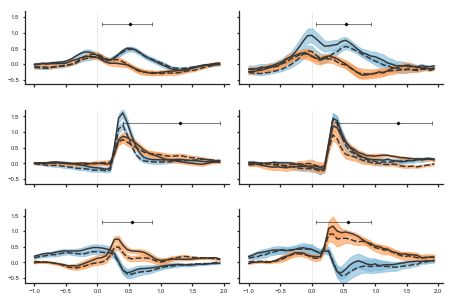

In [102]:
SZ = 8

SZ_S = 6

ylims = [-0.65, 1.70]
sns.set_style('ticks')
figure = plt.figure(figsize=(7.5, 5))
# figure = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2,
                       width_ratios=[3, 3], height_ratios = [ 1, 1, 1])

gs.update(wspace = 0.05, hspace = 0.35)


line_palette = ["#363737", "#363737", "#363737", "#363737"]
fill_palette = ['#7db8da', '#7db8da', '#fd994d', '#fd994d']

latency_names = ["Latency_prez", "Latency_choice", "Latency_reward"]

for num_col, df_fit in enumerate([df_fit_DMS, df_fit_DMS_CB]):
    
    for num_row, timelock in enumerate(['NosePoke', 'LeverPrez', 'Choice']):
        ax = plt.subplot(gs[num_row, num_col])
        sns.lineplot(x = "Time", y = "Estimate", hue = "Cond", 
                     data = df_fit[df_fit['Variable'] == timelock], legend = False, 
                     style = 'Reward_last', style_order= ["1.0", "0.0"], palette = line_palette)
        
        df_i = df_fit[df_fit['Variable'] == timelock]
        


        for ln_i, [cond, color] in enumerate(zip(pd.unique(df_i["Cond"]), fill_palette)):
            df_fill = df_i[df_i["Cond"] == cond]
            ax.fill_between(df_fill['Time'], df_fill['Estimate'] - df_fill['StdError'], df_fill['Estimate'] + df_fill['StdError'], 
                                     color = color, alpha = 0.6)
            


        recordloc = df_fit["RecordLoc"].values[0]
        latency_name = latency_names[num_row]
        df_lat_i = df_lat_sum[(df_lat_sum["Latency_type"] == latency_name) & (df_lat_sum["RecordLoc"] == recordloc)]
        lat_mean = df_lat_i["Mean"]
        lat_5 = df_lat_i["lower_5"].values[0]
        lat_95 = df_lat_i["upper_95"].values[0]
        ax.errorbar(lat_mean, 1.3, xerr =np.array([[lat_5 , lat_95]]).T, fmt = 'D', ms = 2, lw = 0.5, capsize = 2, capthick = 0.5, color = 'k') 
        # aesthetics 
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8)
        ax.axhline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
        ax.set_ylim(ylims)

        if num_col > 0:
            ax.set_yticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(labelsize = SZ_S, length = 2.5)
        if num_row < 2:
            ax.set_xticklabels([])
sns.despine() 

plt.savefig('figs/FigR6A_for_ai.pdf',transparent = True, quality = 95)


In [103]:
#QVALS

analysis_type = "multiple_event_reg_qvals.csv"
# pull data and drop intercepts 
df_fit_DMS = pd.read_csv("data/DMS/" + analysis_type, index_col = 0 )
df_fit_DMS_CB = pd.read_csv("data/DMS_CB/" + analysis_type, index_col = 0 )

df_fit_DMS["RecordLoc"] = "DMS"
df_fit_DMS_CB["RecordLoc"] = "DMS_CB"

# ugh somehow can't filter this out in the for loop 
df_fit_DMS = df_fit_DMS[df_fit_DMS["Cond"] != "Intercept"]
df_fit_DMS_CB = df_fit_DMS_CB[df_fit_DMS_CB["Cond"] != "Intercept"]

for df_fit in (df_fit_DMS, df_fit_DMS_CB):

    # add p values for qvals regression
    df_fit["z"] = df_fit['Estimate'].values / df_fit['StdError'].values
    # some form of  ccdf.(Chisq(1), abs2.(z)) TODO double check 
    (_, pval_corrected, _, _) = multitest.multipletests(1 - scipy.stats.chi2.cdf(np.abs(df_fit['z'].values) ** 2, 1), method = 'fdr_bh')
    df_fit["Pval"] = pval_corrected




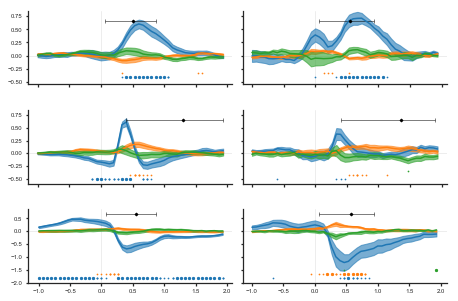

In [105]:
SZ = 8

SZ_S = 6

ylims = [[-0.55, 0.85], [-0.6, 0.85], [-2, 0.85]]
sns.set_style('ticks')
figure = plt.figure(figsize=(7.5, 5))
# figure = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2,
                       width_ratios=[3, 3], height_ratios = [ 1, 1, 1])

gs.update(wspace = 0.05, hspace = 0.35)




qval_palette = sns.color_palette('tab10', 3)

sig = [0.05, 0.01, 0.001]
sig_sz = [0.5, 1, 5]
pval_gap = [0.07, 0.07, 0.15]
pval_center = [-0.4, -0.5, -1.8]


for num_col, df_fit in enumerate([df_fit_DMS, df_fit_DMS_CB]):
    
    for num_row, timelock in enumerate(['NosePoke', 'LeverPrez', 'Choice']):
        ax = plt.subplot(gs[num_row, num_col])
        sns.lineplot(x = "Time", y = "Estimate", hue = "Cond", 
                     data = df_fit[df_fit['Variable'] == timelock], legend = False, 
                     palette = qval_palette)
        
        df_i = df_fit[df_fit['Variable'] == timelock]
        


        for ln_i, [cond, color] in enumerate(zip(pd.unique(df_i["Cond"]), qval_palette)):
            df_fill = df_i[df_i["Cond"] == cond]
            ax.fill_between(df_fill['Time'], df_fill['Estimate'] - df_fill['StdError'], df_fill['Estimate'] + df_fill['StdError'], 
                                     color = color, alpha = 0.6)
            

            for s_i, s in enumerate(sig):
                x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_fill['Pval']  <= s]
                y = np.ones(len(x)) * pval_center[num_row] + ln_i * pval_gap[num_row]

                ax.scatter(x, y, color = color, s = sig_sz[s_i])
        # plot latencies 
        recordloc = df_fit["RecordLoc"].values[0]
        latency_name = latency_names[num_row]
        df_lat_i = df_lat_sum[(df_lat_sum["Latency_type"] == latency_name) & (df_lat_sum["RecordLoc"] == recordloc)]
        lat_mean = df_lat_i["Mean"]
        lat_5 = df_lat_i["lower_5"].values[0]
        lat_95 = df_lat_i["upper_95"].values[0]

        lat_95 = df_lat_i["upper_95"].values[0]
        ax.errorbar(lat_mean, 0.65, xerr =np.array([[lat_5 , lat_95]]).T, fmt = 'D', ms = 2, lw = 0.5, capsize = 2, capthick = 0.5, color = 'k')
        # aesthetics 
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8)
        ax.axhline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

        ax.set_ylim(ylims[num_row])

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(labelsize = SZ_S, length = 2.5)
        if num_row < 2:
            ax.set_xticklabels([])
        if num_col > 0:
            ax.set_yticklabels([])
sns.despine() 

plt.savefig('figs/FigR6B_for_ai.pdf',transparent = True, quality = 95)


In [27]:
df_lat_sum

,RecordLoc,Latency_type,Mean,STD
0,DMS,Latency_prez,0.513382,0.291767
1,DMS,Latency_choice,1.298681,1.465625
2,DMS_CB,Latency_prez,0.546605,0.329610
3,DMS_CB,Latency_choice,1.356595,1.295423


# Heatmaps
I'd like to see **individual session examples** of the photometry data, in a heat plot format, preferably not Z-scored. Some sessions to illustrate the effect on actual trials in real data.



In [109]:
df_gcamp = pd.read_csv(os.path.join('data/', 'timelocked_gcamp_dms_RAW.csv'))
df_gcamp['g_lp'] = df_gcamp['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))

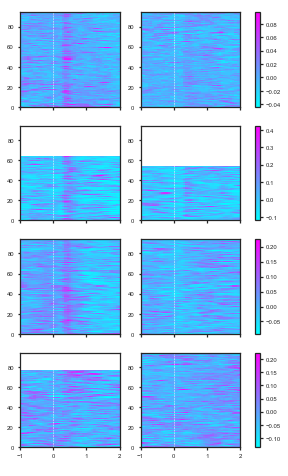

In [210]:
recordloc = "DMS" 
recordloc_str = "Terminals"



sample_sessions = [[1, 1], [5, 3], [3, 5], [11, 2]]

fig = plt.subplots(figsize = (4.5, 2 * len(sample_sessions)))

gs = gridspec.GridSpec(len(sample_sessions), 3, width_ratios = [1, 1, 0.1])
gs.update(wspace = 0.3)
SZ_S = 6


for num_row, session_i in enumerate(sample_sessions):

    df_src_g = df_gcamp[(df_gcamp['RecordLoc'] == recordloc) & 
                            (df_gcamp['MouseID'] == session_i[0]) & (df_gcamp['Session'] == session_i[1])]

    colorbar_min = np.min(np.stack(df_src_g['g_lp'].values, axis=0))
    colorbar_max = np.max(np.stack(df_src_g['g_lp'].values, axis=0))
    ylim_max = max(df_src_g.groupby('Action').count()['Trial'])
    for num_col, (act, act_name) in enumerate(zip(['Con', 'Ips'], ['Contra', 'Ipsi'])):

        df_src_g_i = df_src_g[(df_src_g['Action'] == act)]

        # plot

        src_g_lp = np.stack(df_src_g_i['g_lp'].values, axis=0)

        if act_i == 0:
            ax1 = plt.subplot(gs[num_row, num_col])
            ax = ax1

        else:
            ax2 = plt.subplot(gs[num_row, num_col], sharey = ax1)
#             plt.setp(ax2.get_yticklabels(), visible=False)
            ax = ax2
        
        if num_row < len(sample_sessions) - 1:
            ax.xaxis.set_ticklabels([])
        ax.set_ylim([0, ylim_max])
        g = ax.imshow(src_g_lp, aspect = 'auto',extent = [-1.0, 2.0, len(src_g_lp), 0], cmap = 'cool', vmin = colorbar_min, vmax = colorbar_max)

        # to test the correctness of shared colorbar
    #     cbar = plt.colorbar(g, ax = ax, orientation = 'horizontal')
    #     cbar.ax.tick_params(labelsize=SZ_S) 

        ax.axvline(0, color = 'w', linestyle = '--', linewidth = 0.5)
        ax.tick_params(labelsize = SZ_S, length = 2.5)

    lax = plt.subplot(gs[num_row, -1])
    lax.axis('off')
    cb = plt.colorbar(g, ax = lax, fraction = 1.6)
    cb.ax.tick_params(labelsize = SZ_S, length = 2.5)

    cb.ax.yaxis.set_ticks_position('right')
    
    


plt.savefig('figs/FigR5_for_ai.pdf',transparent = True, quality = 95)



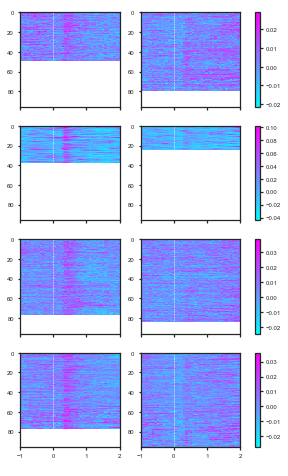

In [231]:
recordloc = "DMS_CB" 




sample_sessions = [[1, 3], [5, 2], [3, 1], [6, 2]]

fig = plt.subplots(figsize = (4.5, 2 * len(sample_sessions)))

gs = gridspec.GridSpec(len(sample_sessions), 3, width_ratios = [1, 1, 0.1])
gs.update(wspace = 0.3)
SZ_S = 6


for num_row, session_i in enumerate(sample_sessions):

    df_src_g = df_gcamp[(df_gcamp['RecordLoc'] == recordloc) & 
                            (df_gcamp['MouseID'] == session_i[0]) & (df_gcamp['Session'] == session_i[1])]

    colorbar_min = np.min(np.stack(df_src_g['g_lp'].values, axis=0))
    colorbar_max = np.max(np.stack(df_src_g['g_lp'].values, axis=0))
    ylim_max = max(df_src_g.groupby('Action').count()['Trial'])
    for num_col, (act, act_name) in enumerate(zip(['Con', 'Ips'], ['Contra', 'Ipsi'])):

        df_src_g_i = df_src_g[(df_src_g['Action'] == act)]

        # plot

        src_g_lp = np.stack(df_src_g_i['g_lp'].values, axis=0)

        if act_i == 0:
            ax1 = plt.subplot(gs[num_row, num_col])
            ax = ax1

        else:
            ax2 = plt.subplot(gs[num_row, num_col], sharey = ax1)
#             plt.setp(ax2.get_yticklabels(), visible=False)
            ax = ax2
        
        if num_row < len(sample_sessions) - 1:
            ax.xaxis.set_ticklabels([])
#         ax.set_ylim([ylim_max, 0 ])
        g = ax.imshow(src_g_lp, aspect = 'auto',extent = [-1.0, 2.0, len(src_g_lp), 0], cmap = 'cool', vmin = colorbar_min, vmax = colorbar_max)

        # to test the correctness of shared colorbar
    #     cbar = plt.colorbar(g, ax = ax, orientation = 'horizontal')
    #     cbar.ax.tick_params(labelsize=SZ_S) 

        ax.axvline(0, color = 'w', linestyle = '--', linewidth = 0.5)
        ax.tick_params(labelsize = SZ_S, length = 2.5)

    lax = plt.subplot(gs[num_row, -1])
    lax.axis('off')
    cb = plt.colorbar(g, ax = lax, fraction = 1.6)
    cb.ax.tick_params(labelsize = SZ_S, length = 2.5)

    cb.ax.yaxis.set_ticks_position('right')
    
    


plt.savefig('figs/FigR5B_for_ai.pdf',transparent = True, quality = 95)



In [229]:
df_src_g = df_gcamp[(df_gcamp['RecordLoc'] == recordloc) & 
                            (df_gcamp['MouseID'] == 5) & (df_gcamp['Session'] == 2)]
    
df_src_g['Action'].value_counts()
df_src_g_i = df_src_g[(df_src_g['Action'] == 'Ips')]
src_g_lp = np.stack(df_src_g_i['g_lp'].values, axis=0)


In [230]:
df_src_g_i.shape

(94, 15)

# Reversals

In [227]:
highprob_blocks = df_trials.HighProb[30:200]

In [228]:
highprob_blocks.value_counts()

Ips    90
Con    80
Name: HighProb, dtype: int64

In [229]:
# now to determine avg reversals per session with df_trials. 
# df.loc[df['mouseID'] == mouse, 'sessionID'] = df.loc[df['mouseID'] == mouse, 'sessionID'].replace(di)

df_corr_all['HighProb_num'] = df_corr_all['HighProb'].replace({'Ips':1, 'Con':0})
df_corr_all['Reversal'] = abs(df_corr_all.groupby([df_corr_all['MouseID'], df_corr_all['Session'], df_corr_all['RecordLoc']])['HighProb_num'].diff())


In [230]:
reversals_per_sess = df_corr_all.groupby([df_corr_all['MouseID'], df_corr_all['Session']])['Reversal'].value_counts()


In [231]:
reversals_per_sess.groupby(['Reversal']).mean()

Reversal
0.0    313.000000
1.0     12.630435
Name: Reversal, dtype: float64

# early vs late analysis

In [232]:
df_DMS = df_corr_all[df_corr_all['RecordLoc'] == 'DMS']
df_DMS_CB = df_corr_all[df_corr_all['RecordLoc'] == 'DMS_CB']
df_DMS.columns

df_src = df_DMS
RECORDLOC = "DMS_CB"
RECORDLOC_STR = "VTA/SN::DMS Cell-Bodies"

In [233]:
# checking block lengths
reversal_starts = np.where(df_src['Reversal'] == 1)[0]
block_lens = reversal_starts[1:] - reversal_starts[:-1] 

min(block_lens)
# 12 for df_DMB, 13 for df_DMB_CB

12

In [234]:


# split trials early vs late for BLOCKS (take first and last 5 trials)

num_trials = 6 # min length is 12, mice need at least 10 correct trials. 
df_early = pd.DataFrame()
df_late = pd.DataFrame()



for mice in np.arange(12): 
    data_mice = df_src[df_src['MouseID'] == mice]
    reversal_starts = np.where(data_mice['Reversal'] == 1)[0]
    num_reversals = len(reversal_starts)

    for t, t_next in zip(reversal_starts[:-1],reversal_starts[1:]):
        block_len = t_next - t
        df_early = df_early.append(data_mice[t:(t + num_trials)])
        df_late = df_late.append(data_mice[(t_next - num_trials):t_next])

recordloc_short = np.unique(df_early["RecordLoc"])[0]

df_early.to_csv("data/" + recordloc_short + "/df_early.csv")
df_late.to_csv("data/" + recordloc_short + "/df_late.csv")

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


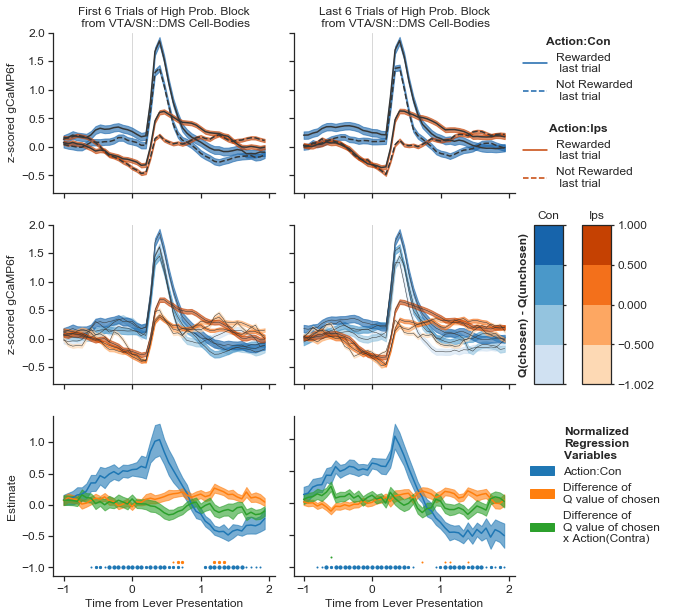

In [235]:
SZ = 15
SZ_S = 12
# no cell-body
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Q(chosen) - Q(unchosen)'
ylims = [[-0.8, 2.0], [-0.8, 2.0], [-1.2, 1.2]]
figure = plt.figure(figsize=(10,10))
subfigs = np.array([['a', 'b', 'c'], ['d', 'e', 'f']])
gs = gridspec.GridSpec(3, 4,
                       width_ratios=[3, 3, 0.4, 0.4])
num_Q_bins = 4
gs.update(wspace=0.15)
line_styles = ['--', '-']
    
for num_col, [df_src, src_name, src_title] in enumerate(zip([df_early, df_late], ['early', 'late'], ['First 6 Trials of High Prob. Block', 'Last 6 Trials of High Prob. Block'])):
    qlims = np.unique(pd.cut(df_src['Q_ch_diff'], num_Q_bins).dropna())
    
    for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):
        j = 0
        timelocked = 'g_lp'
        tl_name = 'Lever Presentation' 
        palettes = [ 'Blues', 'Oranges']
        if tl_name == 'Reward':
            categories = [1, 0]
            column = 'Reward'
            cat_names = ['CS+', 'CS-']
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            cat_names = categories
        # legend plotting 1. colorbar for the q values 
        if num_col == 1:
            
            for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
                color_palette = sns.color_palette(palette, len(qlims))
                cmap = ListedColormap(color_palette.as_hex())
                bounds = [x.left for x in qlims] + [qlims[-1].right]
                norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
                if i == 1:
                    lax = plt.subplot(gs[i, 2 + p_i ])
                    dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
                    lax.cla()
                    cbar = plt.colorbar(dummy_plot, cax = lax)
                    cbar.ax.set_title(subcat, size = SZ_S)
                    if p_i == 0:
                        cbar.ax.set_yticklabels([])
                        cbar.set_label(Q_to_plot_name, size =  SZ_S, weight = 'bold', labelpad=-50, y=0.5, rotation=90)
                        cbar.ax.tick_params(length = 2.5)
                    if p_i == 1:
                        cbar.ax.tick_params(labelsize = SZ_S, length = 2.5)
        #                     cbar.ax.tick_params(axis='y', direction='inout', left = False, right = True)
                if i == 0:
                    lax2 = plt.subplot(gs[i, -2])
                    ln1, = lax2.plot([], color = color_palette[num_Q_bins - 1], linestyle = line_styles[1], label = 'Rewarded\n last trial')
                    ln2, = lax2.plot([], color = color_palette[num_Q_bins - 1], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                    lgd = plt.legend(bbox_to_anchor=(1.5, 0.5), handles = [ln1, ln2], 
                                         fontsize =  SZ_S, loc= (p_i + 8), title = column + ':' + str(subcat),  frameon=False) #  bbox_to_anchor=(0.5,0.7))
                    plt.setp(lgd.get_title(),fontsize=SZ_S, weight = 'bold')
                    if p_i == 0:
                        lax2.add_artist(lgd)
                    lax2.axis('off')
        ax = plt.subplot(gs[i, num_col])
        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_filtered = df_src[df_src[column] == subcat]
            color_palette = sns.color_palette(palette, len(qlims))
            for l_i, col in zip(lines, color_palette):
                # plot gcamps
                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_filtered[(df_filtered[Q_to_plot] > l_i.left) & (df_filtered[Q_to_plot] <= l_i.right)][timelocked], 0)
                    ls_i = '-'
                    lw = 0.5
                elif src == 'gcamp':
                    gcamp = np.vstack(df_filtered[(df_filtered['Reward_last'] == l_i) & (df_filtered['Stay/Leave'] == 'stay')][timelocked])
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(gcamp, axis = 0)
                    col = color_palette[num_Q_bins - 1]
                    lw = 1.5
                    ls_i = line_styles[l_i]
                error = scipy.stats.sem(y, axis = 0)
                ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                    # title
                if i == 0:
                    plt.title(src_title + "\n from "+ RECORDLOC_STR)
    #                 # y axis 
    #                 tick_interval = 0.25 
    #                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
                plt.ylim(ylims[i])
    #                 if i == 1 or i == 2: 
    #                     n = 2  # Keeps every nth label
    #                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
                if j == 0 and num_col == 0:
                    plt.ylabel('z-scored gCaMP6f', size = SZ_S)
                    # x axis 
                if num_col == 1:
                    ax.yaxis.set_ticklabels([])
                    # grid lines
    #             ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
                ax.tick_params(labelsize = SZ_S, length = 5)

            ax.xaxis.set_ticklabels([])
    
    ax = plt.subplot(gs[-1, num_col])
    lax = plt.subplot(gs[-1, -1])
    
    sig = [0.05, 0.01, 0.001]
    sig_sz = [1, 5, 10]
    pval_gap = 0.08 
    df_src = pd.read_csv("data/" + RECORDLOC + "/df_" + src_name + "_reg_corrected.csv")
    df_src = df_src[df_src['Variable']!= 'Intercept']
    num_var = len(np.unique(df_src['Variable']))
    sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable', 
                 ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))
    for ln_i, [n, col] in enumerate(zip(df_src['Variable'], 
                                        sns.color_palette('tab10', num_var ))):
        df_i = df_src[df_src['Variable'] == n]
        ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                                 color = col, alpha = 0.6)
        for s_i, s in enumerate(sig):
            x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
            y = np.ones(len(x)) * -1 + ln_i * pval_gap
            ax.scatter(x, y, color = col, s = sig_sz[s_i])
            if n == 'Interact':
                n = 'Difference of \nQ value of chosen \nx Action(Contra)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ value of chosen'
            if n == 'ActionIps':
                n = 'Action(Contra)'
                
        plt.ylim(ylims[-1])
        ax.set_xlabel("Time from Lever Presentation", size = SZ_S)
        ax.tick_params(labelsize = SZ_S, length = 5)
        ax.set_ylabel("Estimate", size = SZ_S)
                
        if num_col == 1:
            ax.set_ylabel("")
            ax.yaxis.set_ticklabels([])
            lax.fill_between([], [], [], color = col, label = n)
            lax.axis('off')
            
            
l = 'upper center'
lgd = lax.legend(title = 'Normalized\nRegression\nVariables',
                                 loc = l, bbox_to_anchor=(0.5, 1.0),  frameon=False, fontsize = SZ_S)
plt.setp(lgd.get_title(),fontsize=SZ_S, weight = 'bold') 
# plt.tight_layout(w_pad = 0, h_pad = 0, pad = 0)
sns.despine()

In [86]:
SZ = 8
SZ_S = 6

sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = ''
ylims = [[-0.5, 2.2], [-0.5, 2.2]]
figure = plt.figure(figsize=(7.5, 5))
subfigs = np.array([['a', 'b', 'c'], ['d', 'e', 'f']])
gs = gridspec.GridSpec(3, 4,
                       width_ratios=[3, 3, 0.1, 0.1], height_ratios = [ 1, 1, 1])


num_Q_bins = 4
gs.update(wspace=0.15)


line_styles = ['--', '-']


    
for num_col, [df_src, src_name] in enumerate(zip([df_early, df_late], ['early', 'late'])):

    qlims = np.unique(pd.cut(df_src['Q_ch_diff'], num_Q_bins).dropna())
    
    for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):

        j = 0
        timelocked = 'g_lp'
        tl_name = 'Lever Presentation' 
        palettes = [ 'Blues', 'Oranges']


        if tl_name == 'Reward':
            categories = [1, 0]
            column = 'Reward'
            cat_names = ['CS+', 'CS-']
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            cat_names = categories


        # legend plotting 1. colorbar for the q values 

        if num_col == 1:
            lax2 = plt.subplot(gs[i , -2])

            for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):

                color_palette = sns.color_palette(palette, len(qlims))


                cmap = ListedColormap(color_palette.as_hex())
                bounds = [x.left for x in qlims] + [qlims[-1].right]
                norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
                if i == 1:

                    lax = plt.subplot(gs[i , j + 2 + p_i ])
                    dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
                    lax.cla()
                    cbar = plt.colorbar(dummy_plot, cax = lax)
                    cbar.ax.set_yticklabels([])
                    cbar.ax.tick_params(length = 2.5)


                    cbar.ax.set_title("", size = SZ)


# deleted code here 
                if i == 0:

                    ln1, = lax2.plot([], color = color_palette[num_Q_bins -1], linestyle = line_styles[1], label = 'Rewarded\n last trial')
                    ln2, = lax2.plot([], color = color_palette[num_Q_bins - 1], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                    lax2.axis('off')

#                     lgd = plt.legend(bbox_to_anchor=(1.5, 0.5), handles = [ln1, ln2], 
#                                          fontsize =  SZ, loc= (p_i + 8), title = column + ':' + str(subcat),  frameon=False) #  bbox_to_anchor=(0.5,0.7))
#                     plt.setp(lgd.get_title(),fontsize=SZ, weight = 'bold')

#                     if p_i == 0:
#                         lax2.add_artist(lgd)



#             if i == 1:
#                 with sns.axes_style("white"):
#                     lax_title = plt.subplot(gs[1, 2:])
#                     lax_title.text(0.5, 0.5, column, size = SZ, weight = 'bold', ha = 'center')

#                     lax_title.axis('off')


        ax = plt.subplot(gs[i, j*3 + num_col])



        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_filtered = df_src[df_src[column] == subcat]

            color_palette = sns.color_palette(palette, len(qlims))



            for l_i, col in zip(lines, color_palette):

                # plot gcamps
                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_filtered[(df_filtered[Q_to_plot] > l_i.left) & (df_filtered[Q_to_plot] <= l_i.right)][timelocked], 0)
                    ls_i = '-'
                    lw = 0.5
                elif src == 'gcamp':
                    gcamp = np.vstack(df_filtered[(df_filtered['Reward_last'] == l_i) & (df_filtered['Stay/Leave'] == 'stay')][timelocked])
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(gcamp, axis = 0)
                    col = color_palette[num_Q_bins - 1]
                    lw = 1.5
                    ls_i = line_styles[l_i]

                error = scipy.stats.sem(y, axis = 0)
                ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)

                    # title
    #                 if i == 0:
    #                     plt.title('GCaMP filtered with ' + src)



    #                 # y axis 
    #                 tick_interval = 0.25 
    #                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))

                plt.ylim(ylims[i])
    #                 if i == 1 or i == 2: 
    #                     n = 2  # Keeps every nth label
    #                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
                if j == 0 and num_col == 0:
                    plt.ylabel('z-scored gCaMP6f', size = SZ)

                    # x axis 

                plt.xlabel('')
                ax.xaxis.set_ticklabels([])
                if num_col == 1:
                    ax.yaxis.set_ticklabels([])


                    # grid lines
    #             ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'
                ax.tick_params(labelsize = SZ, length = 2.5)




    i = 2
    ax = plt.subplot(gs[-1, 0 + num_col ])
    if num_col == 1:
        lax = plt.subplot(gs[-1, 2:])
        lax.axis("off")
    Q_vals = 'Q_ch_diff'

    ylim = [-1.2, 1.2]
    sig = [0.05, 0.01, 0.001]
    sig_sz = [0.5, 1, 5]
    pval_gap = 0.12 

    
    df_src = pd.read_csv("data/" + RECORDLOC + "/df_" + src_name + "_reg_corrected.csv")
    df_src = df_src[df_src['Variable']!= 'Intercept']
    df_src.loc[df_src['Variable'] == 'Interact', 'Estimate'] = -df_src[df_src['Variable'] == 'Interact'].Estimate
    df_src.loc[df_src['Variable'] == 'Action:Ips', 'Estimate'] = -df_src[df_src['Variable'] == 'Action:Ips'].Estimate


    num_var = len(np.unique(df_src['Variable']))
    sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable', 
                 ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

    for ln_i, [n, col] in enumerate(zip(df_src['Variable'], 
                                        sns.color_palette('tab10', num_var ))):
        df_i = df_src[df_src['Variable'] == n]
        ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                                 color = col, alpha = 0.6)


        for s_i, s in enumerate(sig):
            x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
            y = np.ones(len(x)) * -1 + ln_i * pval_gap

            ax.scatter(x, y, color = col, s = sig_sz[s_i])
            if n == 'Interact':
                n = 'Difference of \nQ value of chosen \nx Action(Contra)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ value of chosen'
            if n == 'ActionIps':
                n = 'Action(Contra)'
#         lax.fill_between([], [], [], color = col, label = n)









    # add subfig label



    ax.set_ylim(ylim)
    if num_col == 0:
        ax.set_ylabel('Estimates', size = SZ)
    else:
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])
    ax.tick_params(labelsize = SZ, length = 2.5)


    ax.set_xticklabels(['-1', '-1', '', '0', '', '1', '', '2'])        

    ax.set_xlabel('', size = SZ)


    # ax.yaxis.grid(True)
    ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'







    
# plt.tight_layout(w_pad = 0, h_pad = 0, pad = 0)
sns.despine()




# plt.savefig('figs/R1b_for_ai.pdf',transparent = True, quality = 95)



NameError: name 'df_early' is not defined

<Figure size 540x360 with 0 Axes>

# Latency

See Julia

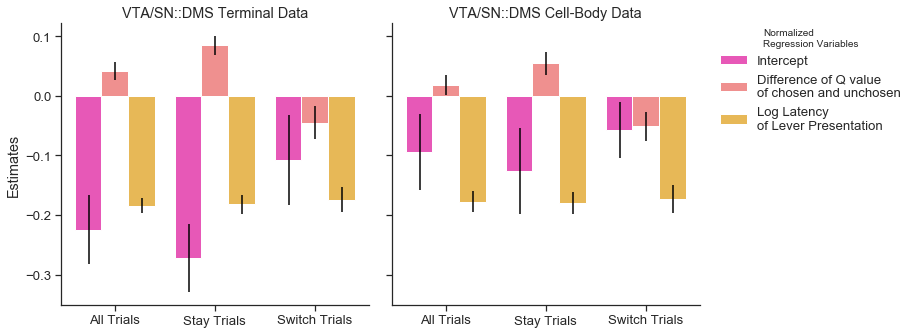

In [81]:


df_lat_reg = pd.read_csv("data/latency_regressions.csv")

def errorbar(x, y, err, order, **kws):
    xnum = [order.index(x_i) for x_i in x]
    offset = np.tile([-0.26, 0, 0.27], 3)

    plt.errorbar(xnum + offset, y, err, color='k', ls = 'none', label = "")

RecordLoc_Dict = {"DMS": "Terminal", "DMS_CB":"Cell-Body"}
g = sns.catplot(x = "StayVSLeave", y = "Estimate",  hue = "Variable", col = "RecordLoc", kind = "bar", data = df_lat_reg.replace({"RecordLoc": RecordLoc_Dict})
, legend = False, palette = "spring")



g.map(errorbar, "StayVSLeave", "Estimate", "StdError", order =  ["All", "Stay", "Leave"])


legend = g.fig.get_axes()[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon = False,
                                    title = "Normalized\nRegression Variables")

new_labels = ["Intercept", "Difference of Q value\nof chosen and unchosen", "Log Latency\nof Lever Presentation"]
for t, l in zip(legend.texts, new_labels): t.set_text(l)
    



(g.set_axis_labels("", "Estimates").
 set_xticklabels(["All Trials", "Stay Trials", "Switch Trials"]).
 set_titles("VTA/SN::DMS {col_name} Data"))
    

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


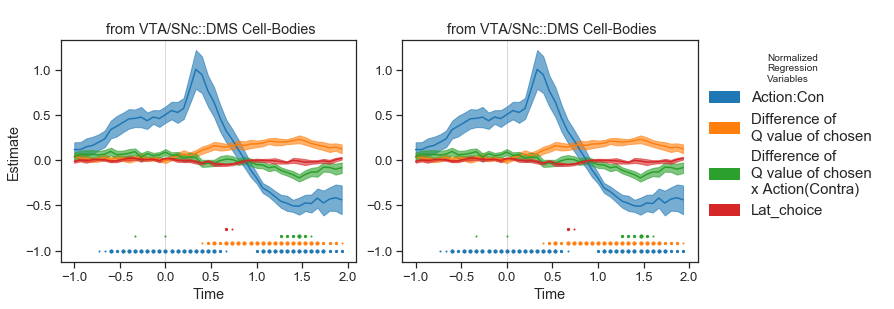

In [97]:
figure = plt.figure(figsize=(14, 9))

gs = gridspec.GridSpec(2, 3,
                       width_ratios=[3, 3, 1], height_ratios = [ 1, 1])
SZ = 15
SZ_S = 7
RECORDLOC = "DMS_CB"
RECORDLOC_STR = "VTA/SNc::DMS Cell-Bodies"

ylims = [-1.0, 1.65]

for num_col, [src, src_name] in enumerate(zip(["DMS", "DMS_CB"], ['',''])):
    ax = plt.subplot(gs[0, num_col])
    lax = plt.subplot(gs[0, -1])
    

    sig = [0.05, 0.01, 0.001]
    sig_sz = [1, 5, 10]
    pval_gap = 0.08 
    df_src = pd.read_csv("data/" + RECORDLOC + "/Julia_lever_latency_corrected.csv")

    df_src = df_src[df_src['Variable']!= 'Intercept']


    num_var = len(np.unique(df_src['Variable']))
    sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable', 
                 ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

    for ln_i, [n, col] in enumerate(zip(df_src['Variable'], 
                                        sns.color_palette('tab10', num_var ))):
        df_i = df_src[df_src['Variable'] == n]
        ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                                 color = col, alpha = 0.6)


        for s_i, s in enumerate(sig):
            x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
            y = np.ones(len(x)) * -1 + ln_i * pval_gap

            ax.scatter(x, y, color = col, s = sig_sz[s_i])
            if n == 'Interact':
                n = 'Difference of \nQ value of chosen \nx Action(Contra)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ value of chosen'
            if n == 'ActionIps':
                n = 'Action(Contra)'
                
        plt.ylim(ylims)
        plt.xlabel("Time from Lever Presentation")
        ax.set_title(src_name + "\n from "+ RECORDLOC_STR)
                
        if num_col == 1:
            ax.set_ylabel("")
            lax.fill_between([], [], [], color = col, label = n)
            lax.axis('off')

        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8)



l = 'upper center'
lgd = lax.legend(title = 'Normalized\nRegression\nVariables',
                                 fontsize = SZ, loc = l, bbox_to_anchor=(0.5, 1.0),  frameon=False)

NameError: name 'RECORDLOC' is not defined

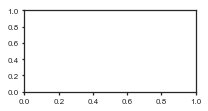

In [6]:


figure = plt.figure(figsize=(6.75, 1.5))

gs = gridspec.GridSpec(1,2)
SZ = 8
SZ_S = 6

ylims = [-1.2, 1.2]
sig = [0.05, 0.01, 0.001]
sig_sz = [0.5, 1, 5]
pval_gap = 0.12

for num_col, [src, src_name] in enumerate(zip(["DMS", "DMS_CB"], ['',''])):
    ax = plt.subplot(gs[0, num_col])
    ax.tick_params(labelsize = SZ, length = 2.5)



    df_src = pd.read_csv("data/" + RECORDLOC + "/Julia_lever_latency_corrected.csv")

    df_src = df_src[df_src['Variable']!= 'Intercept']


    num_var = len(np.unique(df_src['Variable']))
    sns.lineplot(data=df_src, x = 'Time', y = 'Estimate', hue = 'Variable', 
                 ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

    for ln_i, [n, col] in enumerate(zip(df_src['Variable'], 
                                        sns.color_palette('tab10', num_var ))):
        df_i = df_src[df_src['Variable'] == n]
        ax.fill_between(df_i['Time'], df_i['Estimate'] - df_i['StdError'], df_i['Estimate'] + df_i['StdError'], 
                                 color = col, alpha = 0.6)


        for s_i, s in enumerate(sig):
            x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pval']  <= s]
            y = np.ones(len(x)) * -1 + ln_i * pval_gap

            ax.scatter(x, y, color = col, s = sig_sz[s_i])
    
                
        plt.ylim(ylims)
        ax.set_xlabel("")
        ax.set_ylabel("")
                
#         if num_col == 1:
#             ax.set_ylabel("")
#             lax.fill_between([], [], [], color = col, label = n)
#             lax.axis('off')

    ax.set_xticks([-1, -0.5, 0, 0.5, 1, 1.5, 2])
    ax.set_xticklabels(['-1', '',  '0', '', '1', '', '2'])      
    ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8)

sns.despine()


# l = 'upper center'
# lgd = lax.legend(title = 'Normalized\nRegression\nVariables',
#                                  fontsize = SZ, loc = l, bbox_to_anchor=(0.5, 1.0),  frameon=False)


plt.savefig('figs/FigR2_for_ai.pdf',transparent = True, quality = 95)


In [77]:
# calculating the mean/sem for latencies here
df_lat = pd.read_csv("data/latency_qvals_gcamp.csv")

data = []
for recordloc in ["DMS", "DMS_CB"]:

    for lat in ["Latency_prez", "Latency_choice", "Latency_reward"]:
        df_i = df_lat[df_lat["RecordLoc"] == recordloc]
        avg = df_i[lat].mean()
        (lower_5, upper_95) = df_i[lat].quantile([0.05, 0.85])
        data.append([recordloc, lat, avg, avg - lower_5, upper_95 - avg])

df_lat_sum = pd.DataFrame(data, columns = ('RecordLoc', 'Latency_type', 'Mean', 'lower_5', 'upper_95'))
        
df_lat_sum.to_csv("data/lat_summary.csv")

In [78]:
df_lat_sum

,RecordLoc,Latency_type,Mean,lower_5,upper_95
0,DMS,Latency_prez,0.513382,0.446715,0.353285
1,DMS,Latency_choice,1.298681,0.898681,0.634652
2,DMS,Latency_reward,0.547025,0.480359,0.319641
3,DMS_CB,Latency_prez,0.546605,0.479938,0.386729
4,DMS_CB,Latency_choice,1.356595,0.956595,0.540072
5,DMS_CB,Latency_reward,0.577629,0.510963,0.355704


In [38]:
upper_95

4.466666666666667

In [8]:
df_lat_DMS = df_lat[df_lat["RecordLoc"] == "DMS"]

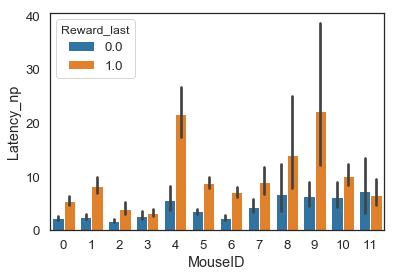

In [164]:
sns.barplot(x = 'MouseID', y = 'Latency_np', hue = 'Reward_last', 
            data = df_lat[(df_lat["RecordLoc"] == "DMS") & (df_lat["Reward"] == 0.0)])

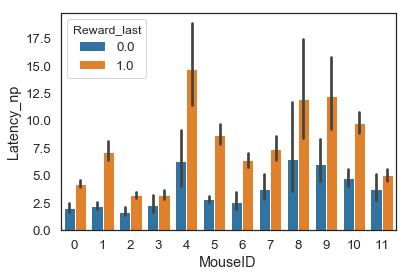

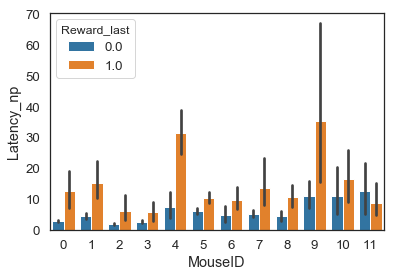

In [157]:
sns.barplot(x = 'MouseID', y = 'Latency_np', hue = 'Reward_last', data = df_lat_DMS[df_lat_DMS['StayVSLeave'] == 'stay'])
plt.figure()
sns.barplot(x = 'MouseID', y = 'Latency_np', hue = 'Reward_last', data = df_lat_DMS[df_lat_DMS['StayVSLeave'] == 'leave'])

In [42]:
sns.scatterplot?

Object `sns.scatterplot` not found.


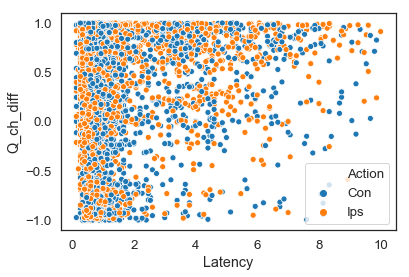

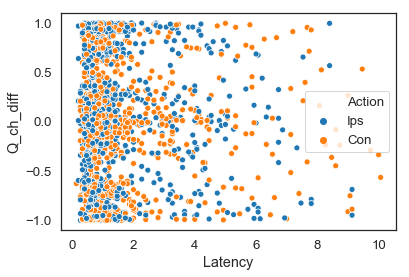

In [7]:

sns.scatterplot(x = 'Latency', y = 'Q_ch_diff', hue = 'Action', data = df_DMS[df_DMS['Stay/Leave'] == 'stay'])
plt.figure()
sns.scatterplot(x = 'Latency', y = 'Q_ch_diff', hue = 'Action', data = df_DMS[df_DMS['Stay/Leave'] == 'leave'])

# checking quantiles

In [7]:

value_cuts = pd.cut(df_DMS['Q_ch_diff'], Q_BINS)
q_cuts = pd.qcut(df_DMS['Q_ch_diff'], Q_BINS)
value_cuts.value_counts()
q_cuts.value_counts()

(0.945, 1.0]         1011
(0.848, 0.945]       1011
(0.714, 0.848]       1011
(0.28, 0.534]        1011
(0.127, 0.28]        1011
(-0.128, 0.00106]    1011
(-0.633, -0.128]     1011
(-1.001, -0.633]     1011
(0.534, 0.714]       1010
(0.00106, 0.127]     1010
Name: Q_ch_diff, dtype: int64

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


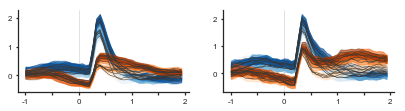

In [78]:

df_DMS['quantilesQ_ch_diff'] = pd.qcut(df_DMS['Q_ch_diff'], Q_BINS)

df_DMS_CB['quantilesQ_ch_diff'] = pd.qcut(df_DMS_CB['Q_ch_diff'], Q_BINS)



figure = plt.figure(figsize=(6.75, 1.5))

gs = gridspec.GridSpec(1,2)
SZ = 8
SZ_S = 6

palettes = ['Blues', 'Oranges']
Q_to_plot = 'Q_ch_diff'
timelocked = 'g_lp'
for num_col, [df_recordloc, src_name] in enumerate(zip([df_DMS, df_DMS_CB], ['DMS', 'DMS_CB'])):
    ax = plt.subplot(gs[0, num_col])
    ax.tick_params(labelsize = SZ, length = 2.5)

    ax.set_xticks([-1, -0.5, 0, 0.5, 1, 1.5, 2])
    ax.set_xticklabels(['-1', '',  '0', '', '1', '', '2'])    

    categories = ['Con', 'Ips']
    column = 'Action'

  

    for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
        df_src = df_recordloc[df_recordloc[column] == subcat]
        qlims = np.unique(df_src['quantilesQ_ch_diff'].dropna())
        color_palette = sns.color_palette(sns.color_palette(palette, len(qlims)))


        for l_i, col in zip(qlims, color_palette):


            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                

            error = np.std(y, axis = 0) / np.sqrt(NS)
            ax.plot(x, y, color = '#363737', linestyle = '-', linewidth = '0.5')
            ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8)
        

    


sns.despine()
# l = 'upper center'
# lgd = lax.legend(title = 'Normalized\nRegression\nVariables',
#                                  fontsize = SZ, loc = l, bbox_to_anchor=(0.5, 1.0),  frameon=False)

plt.savefig('figs/FigR3_for_ai.pdf',transparent = True, quality = 95)


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


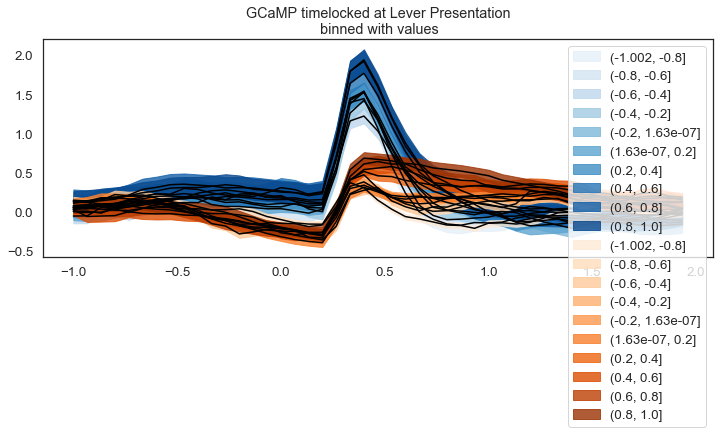

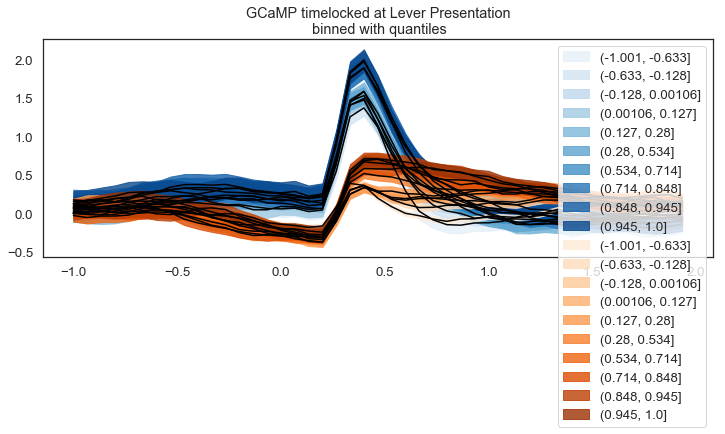

In [106]:

# constants: 





df_DMS['valuesQ_ch_diff'] = pd.cut(df_DMS['Q_ch_diff'], Q_BINS)

df_DMS['quantilesQ_ch_diff'] = pd.qcut(df_DMS['Q_ch_diff'], Q_BINS)






timelocked = 'g_lp'
tl_name = 'Lever Presentation'

categories = ['Con', 'Ips']
column = 'Action'




for bin_type in ['values', 'quantiles']:
    figure = plt.figure(figsize=(12, 4))
    for subcat, palette in zip(categories, ['Blues', 'Oranges']):
        df_src = df_DMS[df_DMS[column] == subcat]


        qlims = np.unique(df_src[bin_type + 'Q_ch_diff'].dropna())
        for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(df_src[(df_src['Q_ch_diff'] > q_i.left) & (df_src['Q_ch_diff'] <= q_i.right)][timelocked], 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k')

            plt.fill_between(x, y-error, y+error, color = col, alpha = 0.8,  label = q_i)
            plt.title('GCaMP timelocked at ' + tl_name + '\n binned with ' + bin_type)
            plt.legend()
    #     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



# Hemisphere Split

For DMS_CB, we have 4 mice but 7 recording sites. Here is the order of the mice: 

12959(R), 12974(L), 12975(L), 12974(R), 12975(R), 12976(L), 12976(R)



In [70]:
pairs = [[1, 3], [2, 4], [5, 6], [-1, 0]] # numbering from 0, going L, R, -1 means empty 


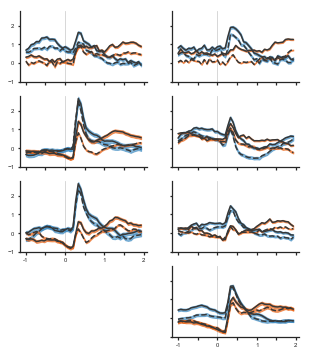

In [77]:
figure = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(4, 2)

categories = ['Con', 'Ips']
column = 'Action'
palettes = ["Blues", "Oranges"]
line_styles = ['--', '-']

num_Q_bins = 2
timelocked = 'g_lp'

ylim = [-1.0, 2.8]
SZ_S = 6
last_row = [2, 3]

for row, pairs_i in enumerate(pairs):
    for col, mouseID in enumerate(pairs_i):
        ax = plt.subplot(gs[row, col])
        ax.set_ylim(ylim)
        ax.tick_params(labelsize = SZ_S, length = 2.5)
        
        ax.set_xticklabels([])
        if col > 0:
            ax.set_yticklabels([])
        if (row == last_row[col]):
            ax.set_xticklabels(['','-1', '', '0', '', '1', '', '2'])

            
        if mouseID == -1:
            ax.axis('off')
        else:
            df_src = df_DMS_CB[df_DMS_CB['MouseID'] == mouseID]
            qlims = np.unique(pd.cut(df_src['Q_ch_diff'], num_Q_bins).dropna())
            for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
                df_filtered = df_src[df_src[column] == subcat]

                color_palette = sns.color_palette(palette, len(qlims))



                for l_i, col in zip(np.arange(2), color_palette):

                    gcamp = np.vstack(df_filtered[(df_filtered['Reward_last'] == l_i) & (df_filtered['Stay/Leave'] == 'stay')][timelocked])
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(gcamp, axis = 0)
                    col = color_palette[1]
                    lw = 1.5
                    ls_i = line_styles[l_i]

                    error = scipy.stats.sem(y, axis = 0)
                    ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
                    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                    ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8)



sns.despine()
plt.savefig('figs/R4_for_ai.pdf',transparent = True, quality = 95)

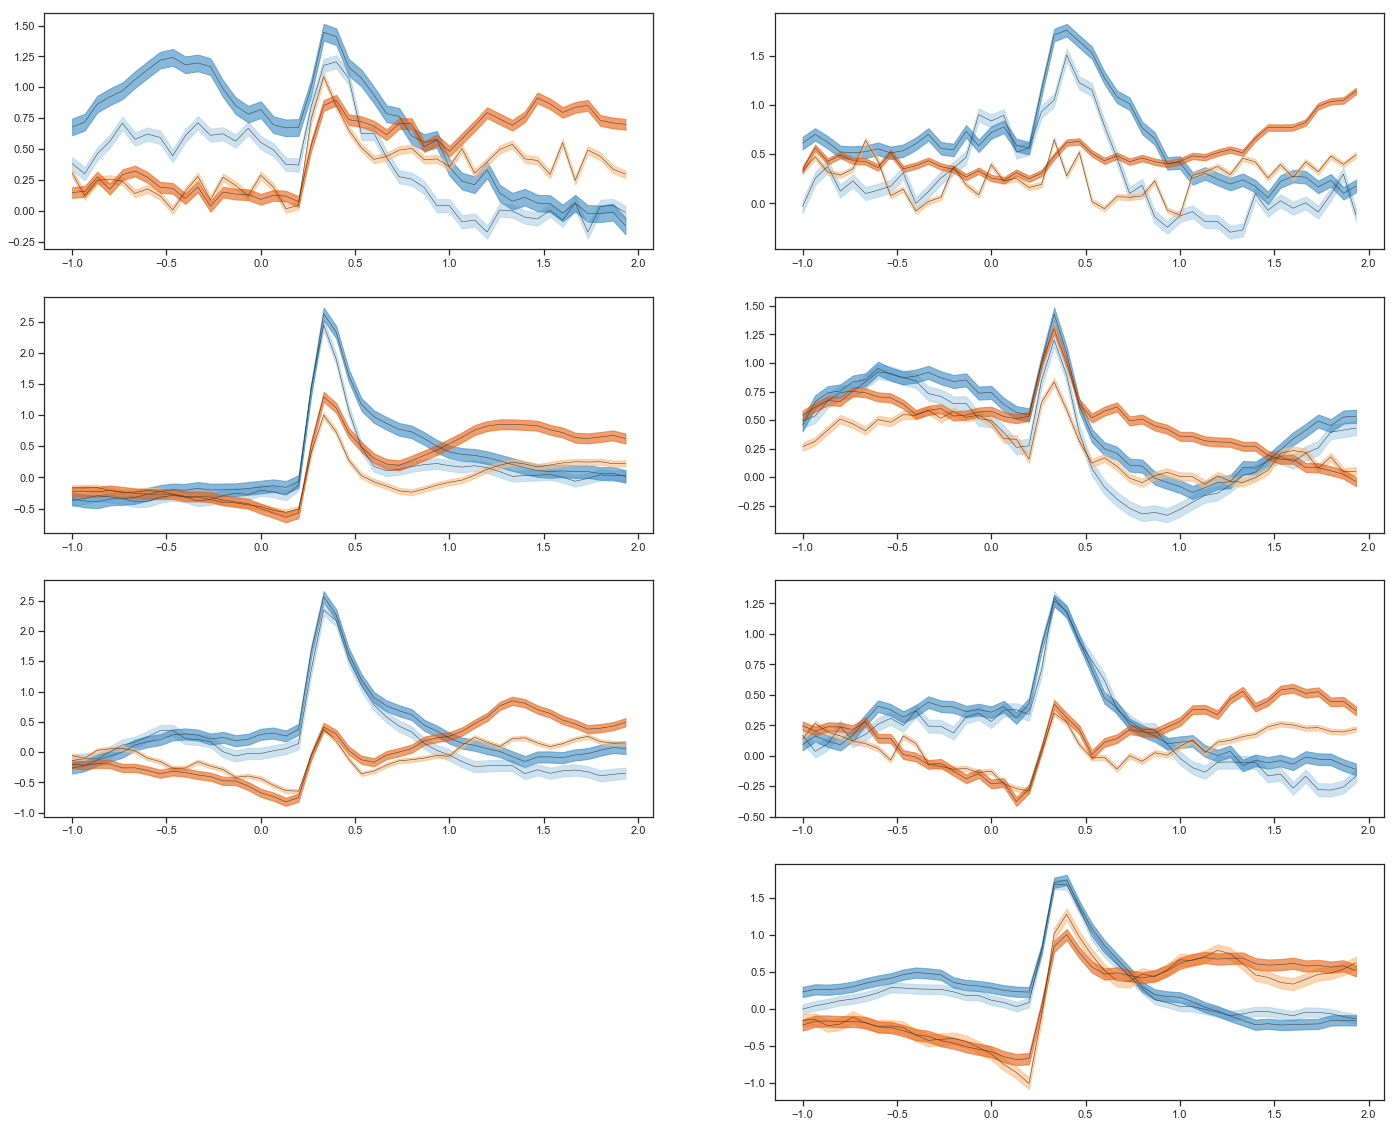

In [25]:
figure = plt.figure(figsize=(24, 20))
gs = gridspec.GridSpec(4, 2)

palettes = ["Blues", "Oranges"]
line_styles = ['--', '-']


for row, pairs_i in enumerate(pairs):
    for col, mouseID in enumerate(pairs_i):
        ax = plt.subplot(gs[row, col])
        if mouseID == -1:
            ax.axis('off')
        else:
            df_src = df_DMS_CB[df_DMS_CB['MouseID'] == mouseID]
            qlims = np.unique(pd.cut(df_src['Q_ch_diff'], num_Q_bins).dropna())

            for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
                df_filtered = df_src[df_src[column] == subcat]

                color_palette = sns.color_palette(palette, len(qlims))



                for l_i, col in zip(qlims, color_palette):

                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_filtered[(df_filtered[Q_to_plot] > l_i.left) & (df_filtered[Q_to_plot] <= l_i.right)][timelocked], 0)
                    ls_i = '-'
                    lw = 0.5

                    error = scipy.stats.sem(y, axis = 0)
                    ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
                    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)


